# Importing Dataset & Libraries

* Decompress Data

In [1]:
!apt-get install p7zip
!p7zip -d -f -k /kaggle/input/mercari-price-suggestion-challenge/train.tsv.7z
!p7zip -d -f -k /kaggle/input/mercari-price-suggestion-challenge/test.tsv.7z
!unzip /kaggle/input/mercari-price-suggestion-challenge/test_stg2.tsv.zip




p7zip is already the newest version (16.02+dfsg-7build1).
p7zip set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 66 not upgraded.

7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=C.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /kaggle/input/mercari-price-suggestion-challenge/                                                           1 file, 77912192 bytes (75 MiB)

Extracting archive: /kaggle/input/mercari-price-suggestion-challenge/train.tsv.7z
--
Path = /kaggle/input/mercari-price-suggestion-challenge/train.tsv.7z
Type = 7z
Physical Size = 77912192
Headers Size = 122
Method = LZMA2:24
Solid = -
Blocks = 1

  0%      2% - train.tsv                  6% - train.t

In [2]:
import numpy as np 
import pandas as pd 
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
import lzma
import os
import csv
import re
import time

In [4]:
train = pd.read_csv('/kaggle/working/train.tsv', sep='\t')
test = pd.read_csv('/kaggle/working/test_stg2.tsv', sep='\t')
print("train data: ",train.shape)
print("test data: ",test.shape)

train data:  (1482535, 8)
test data:  (3460725, 7)


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3460725 entries, 0 to 3460724
Data columns (total 7 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   test_id            int64 
 1   name               object
 2   item_condition_id  int64 
 3   category_name      object
 4   brand_name         object
 5   shipping           int64 
 6   item_description   object
dtypes: int64(3), object(4)
memory usage: 184.8+ MB


In [7]:
train

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity
...,...,...,...,...,...,...,...,...
1482530,1482530,Free People Inspired Dress,2,Women/Dresses/Mid-Calf,Free People,20.0,1,"Lace, says size small but fits medium perfectl..."
1482531,1482531,Little mermaid handmade dress,2,Kids/Girls 2T-5T/Dresses,Disney,14.0,0,Little mermaid handmade dress never worn size 2t
1482532,1482532,21 day fix containers and eating plan,2,Sports & Outdoors/Exercise/Fitness accessories,NaN,12.0,0,"Used once or twice, still in great shape."
1482533,1482533,World markets lanterns,3,Home/Home Décor/Home Décor Accents,NaN,45.0,1,There is 2 of each one that you see! So 2 red ...


In [8]:
test

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...
...,...,...,...,...,...,...,...
3460720,3460720,DARK SAMPLE BYE FOUNDATION MOISTURIZER,1,Beauty/Fragrance/Women,NaN,1,It cosmetics Bye Bye Foundation Full Coverage ...
3460721,3460721,bundle for @brandystash,2,Women/Pants/Other,NaN,1,♡2 pairs of omighty trackiez. one m and one s....
3460722,3460722,Toddler High-top Converse,3,Kids/Girls 0-24 Mos/Shoes,Nike,0,Size 5 (toddler). Pink high top converse shoes...
3460723,3460723,Yoga Sling Sandals,1,Women/Shoes/Sandals,Sanuk,1,super super comfy. i have a pair but ordered t...


# Data Visualization

Total Number of brands are 4809


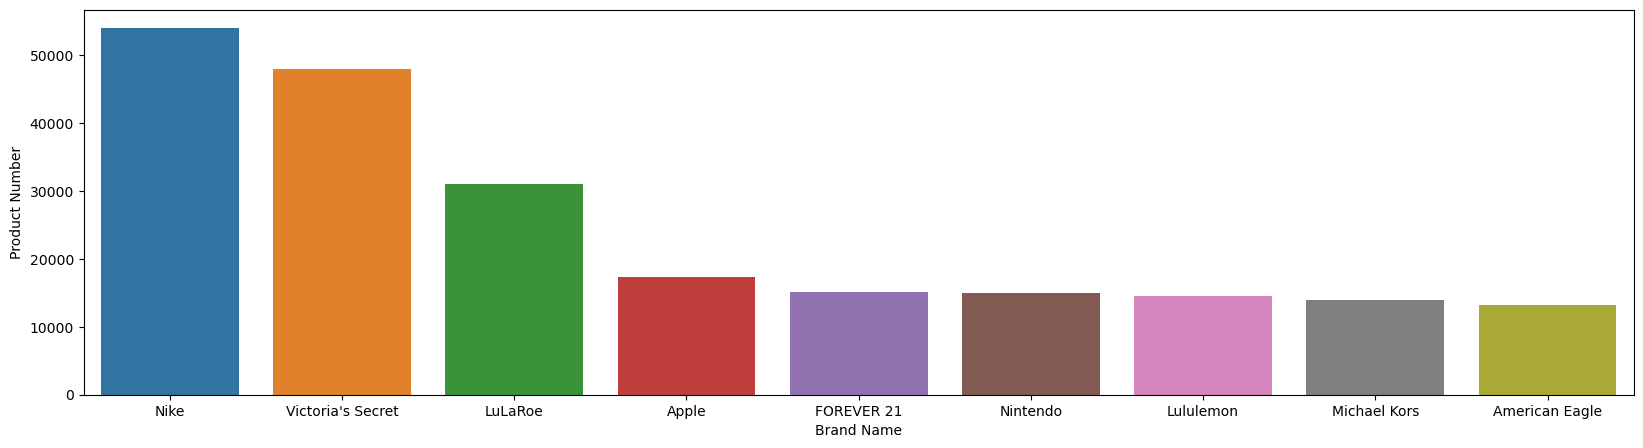

In [9]:
unique_brands = train['brand_name'].value_counts()
print("Total Number of brands are {}".format(len(unique_brands)))
plt.figure(figsize=(20, 5))
sns.barplot(x=unique_brands.index[1:10], y=unique_brands[1:10])
plt.xlabel('Brand Name')
plt.ylabel('Product Number')
plt.show()

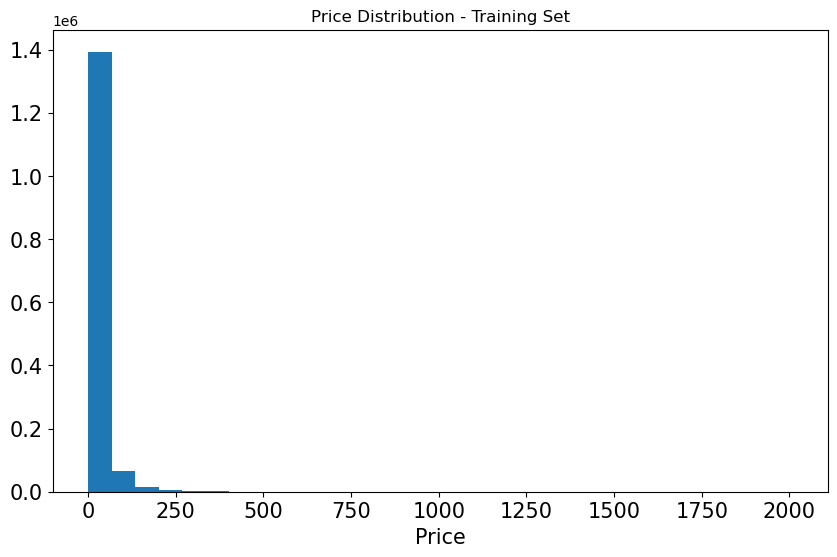

In [10]:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(train.price,bins = 30, range = [min(train.price), max(train.price)],label="Price")
plt.tick_params(labelsize=15)
ax.set_xlabel('Price',fontsize=15)
plt.title('Price Distribution - Training Set')
plt.show()

-We have many items with concentrated price below 500$, the price distribution is skewed to the right

-Use the covariate function to return to the normal distribution

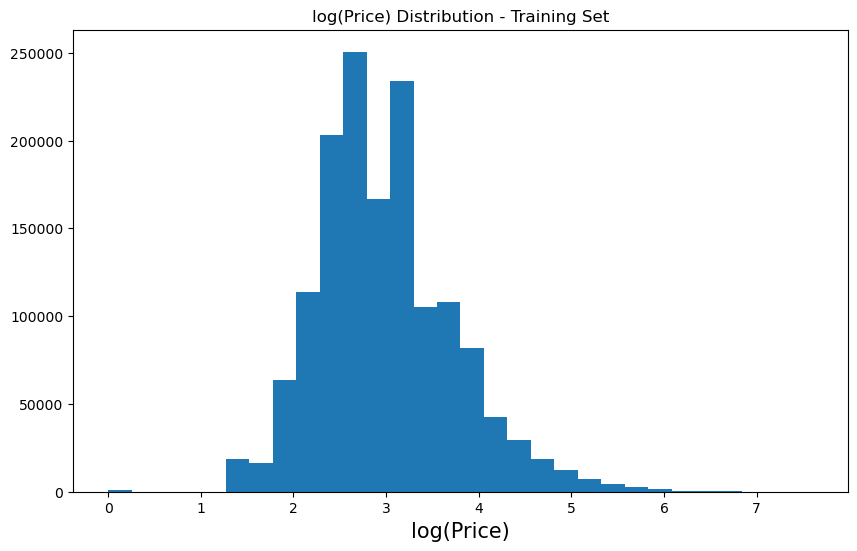

In [11]:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(np.log1p(train['price']),bins = 30, range = [min(np.log1p(train['price'])), max(np.log1p(train['price']))],label="Price")
ax.set_xlabel('log(Price)',fontsize=15)
plt.title('log(Price) Distribution - Training Set')
plt.show()

-Check the condition of the product  

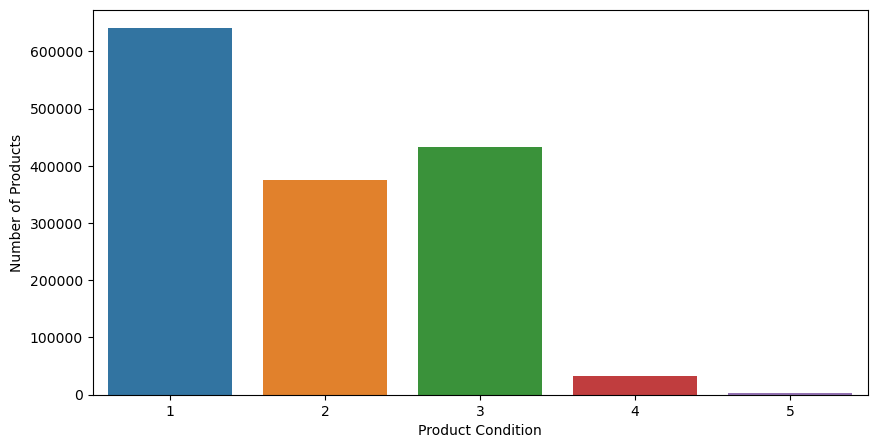

In [12]:
count = train['item_condition_id'].value_counts()
plt.figure(figsize=(10, 5))
sns.barplot(x=count.index[:5],y=count[:5])
plt.ylabel('Number of Products')
plt.xlabel('Product Condition')
plt.show()

-Check Shipping Fees

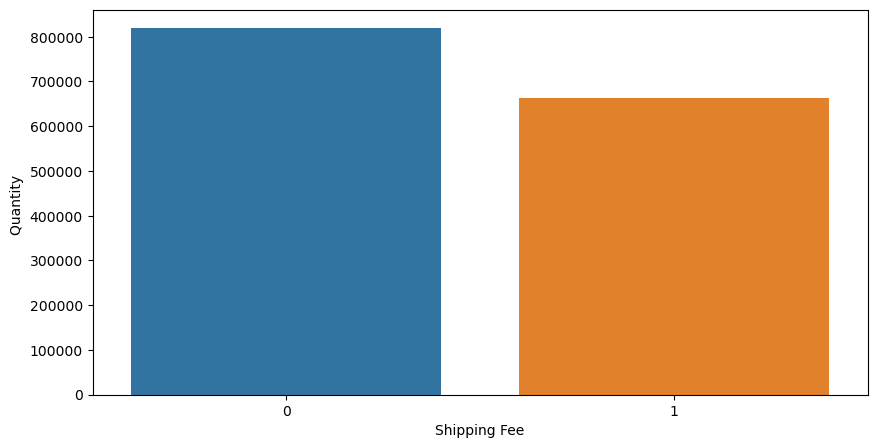

In [13]:
count = train['shipping'].value_counts()
plt.figure(figsize=(10, 5))
sns.barplot(x=count.index[:2], y=count[:2])
plt.ylabel('Quantity ')
plt.xlabel('Shipping Fee')
plt.show()

# Data Preprocessing

In [14]:
def split_cat(text):
    try: return text.split("/")
    except: return ("None", "None", "None")
train['category_1'], train['category_2'], train['category_3'] = \
zip(*train['category_name'].apply(lambda x: split_cat(x)))
test['category_1'], test['category_2'], test['category_3'] = \
zip(*test['category_name'].apply(lambda x: split_cat(x)))

train.head(5)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category_1,category_2,category_3
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [15]:
train.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
category_1                0
category_2                0
category_3                0
dtype: int64

In [16]:
test.isnull().sum()

test_id                    0
name                       0
item_condition_id          0
category_name          14833
brand_name           1476490
shipping                   0
item_description           6
category_1                 0
category_2                 0
category_3                 0
dtype: int64

In [17]:
def handle_missing(dataset):
    dataset.brand_name.fillna(value="None", inplace=True)
    dataset.item_description.fillna(value="None", inplace=True)
    dataset.category_name.fillna(value="None", inplace=True)
    return (dataset)

train = handle_missing(train)
test = handle_missing(test)

In [18]:
train.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
category_1           0
category_2           0
category_3           0
dtype: int64

In [19]:
#Group the product name by price
def create_price_d(grouped, operation_name, orig_colname):
    price_d = {}
    for index, row in grouped.iterrows():
        price_d[row[orig_colname]] = row['price']
    return {orig_colname + "_" + operation_name: price_d}


# Generate data to look up prices by product name
price_d = {}    
for col in ['brand_name','category_1','category_2','category_3' ,'category_name']:
    price_d.update(create_price_d(train.groupby(col, as_index=False).min(), 'min', col))
    price_d.update(create_price_d(train.groupby(col, as_index=False).median(), 'median', col))
    price_d.update(create_price_d(train.groupby(col, as_index=False).mean(), 'mean', col))
    price_d.update(create_price_d(train.groupby(col, as_index=False).max(), 'max', col))

    
#Include columns containing dummy products in data
def price_dt(dt, pricedicts):
    for col in ['brand_name','category_1','category_2','category_3','category_name']:
        for oper in ['_min', '_median', '_mean', '_max']:
            dt[col + oper] = dt[col].map(price_d[col + oper])
            dt[col + oper] = dt[col + oper].fillna(price_d[col + oper].get('Unknown', 5))

price_dt(train, price_dt)
price_dt(test, price_dt)

In [20]:
train.head(5)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category_1,category_2,...,category_2_mean,category_2_max,category_3_min,category_3_median,category_3_mean,category_3_max,category_name_min,category_name_median,category_name_mean,category_name_max
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,None,10.0,1,No description yet,Men,Tops,...,18.999442,375.0,0.0,14.0,18.352495,309.0,0.0,14.0,18.352495,309.0
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,...,87.887754,1900.0,3.0,25.0,42.913900,750.0,3.0,25.0,42.913900,750.0
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,...,18.237514,1525.0,0.0,12.0,15.659676,329.0,0.0,12.0,15.660102,329.0
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,None,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,...,21.566301,848.0,0.0,16.0,22.185020,848.0,0.0,16.0,22.185020,848.0
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,None,44.0,0,Complete with certificate of authenticity,Women,Jewelry,...,27.501571,2004.0,0.0,12.0,25.587509,1747.0,0.0,12.0,25.587509,1747.0


In [21]:
col = ['item_condition_id', 
       'shipping', 
      'brand_name_min', 
       'brand_name_max', 
       'brand_name_median', 
       'brand_name_mean', 
      'category_name_min', 
       'category_name_max', 
       'category_name_median', 
       'category_name_mean'
      ]

train_col = train[col]
train_pr = train[['price']]

test_col = test[col]

# Machine Learning Model Evaluations and Predictions

## Logistic Regression

In [22]:
#Train the model using linear regression
regr = linear_model.LinearRegression()
regr.fit(train_col, train_pr)

# Generate price prediction on test dataset
test['price'] = regr.predict(test_col)

#Reduce price prediction less than 0 to 8
test.loc[test.price < 0, 'price'] = 0

In [23]:
RESULT_col = test[['test_id', 'price']]
RESULT_col

,test_id,price
0,0,25.496219
1,1,12.589569
2,2,112.516602
3,3,24.609692
4,4,7.471231
...,...,...
3460720,3460720,21.440157
3460721,3460721,17.167976
3460722,3460722,20.652720
3460723,3460723,25.465235
